<a href="https://colab.research.google.com/github/Tomawock/MLDM_COVID-19/blob/master/covid_dividiamo_modelli_dtr_grid_test_toma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-DIVIDIAMO

## CREAZIONE DI MODELLI basati su DT

Questo notebook ha lo scopo di addestrare alcuni **modelli** di predizione per il nostro dataset basati su **Alberi di Decisione (DT)**. Per farlo, utilizzeremo nuovamente la procedura automatizzata tramite **grid search**.

In [85]:
%autosave 30
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 8)

import joblib
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, max_error

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

Autosaving every 30 seconds
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### MODELLO: preparazione dei datasets

**Carichiamo** il dataset ed impostiamo il **random state**. Trasformiamo l'attributo nominale in numerico.

**Dividiamo** il dataset in:
* **training** set
* **testing** set

Proviamo utilizzando l'**80%** dei records per il training set ed il restante per il testing.

In [86]:
df_2 = pd.read_csv("/content/drive/Shared drives/MLDM progetto/Datasets/dataset_finale_medie_2_week.csv", parse_dates=["Data"], infer_datetime_format=True)
df_1 = pd.read_csv("/content/drive/Shared drives/MLDM progetto/Datasets/dataset_finale_medie_1_week.csv", parse_dates=["Data"], infer_datetime_format=True)
df_0 = pd.read_csv("/content/drive/Shared drives/MLDM progetto/Datasets/dataset_finale_medie.csv", parse_dates=["Data"], infer_datetime_format=True)

rnd_state = 146645
predictor_columns = ['pass_Altezza Neve', 'pass_Ammoniaca', 'pass_Benzene',
       'pass_Biossido di Azoto', 'pass_Biossido di Zolfo', 'pass_BlackCarbon',
       'pass_Direzione Vento', 'pass_Livello Idrometrico',
       'pass_Monossido di Azoto', 'pass_Monossido di Carbonio',
       'pass_Ossidi di Azoto', 'pass_Ozono', 'pass_PM10 (SM2005)',
       'pass_Particelle sospese PM2.5', 'pass_Precipitazione',
       'pass_Radiazione Globale', 'pass_Temperatura', 'pass_Umidità Relativa',
       'pass_Velocità Vento', 'pass_deceduti', 'pass_dimessi_guariti',
       'pass_isolamento_domiciliare', 'pass_nuovi_positivi',
       'pass_ricoverati_con_sintomi', 'pass_tamponi', 'pass_terapia_intensiva',
       'pass_totale_casi', 'pass_totale_ospedalizzati', 'pass_totale_positivi',
       'pass_variazione_totale_positivi']


**Prepariamo** il **training** set ed il **test** set per il data set relativo ai **sette giorni precedenti**

In [87]:
train_1 = df_1.sample(frac=0.70, random_state=rnd_state)
test_1 = df_1.drop(train_1.index)

train_X_1 = train_1[predictor_columns]
train_y_1 = train_1["fut1_nuovi_positivi"]

test_X_1 = test_1[predictor_columns]
test_y_1 = test_1["fut1_nuovi_positivi"]

**Prepariamo** il **training** set ed il **test** set per il data set relativo all'interllo fra i **quattordici e sette giorni precedenti**



In [88]:
train_2 = df_2.sample(frac=0.70, random_state=rnd_state)
test_2 = df_2.drop(train_2.index)

train_X_2 = train_2[predictor_columns]
train_y_2 = train_2["fut1_nuovi_positivi"]

test_X_2 = test_2[predictor_columns]
test_y_2 = test_2["fut1_nuovi_positivi"]

**Prepariamo** il **training** set ed il **test** set per il data set relativo all'interllo dei **quattordici giorni precedenti**


In [89]:
train_0 = df_0.sample(frac=0.70, random_state=rnd_state)
test_0 = df_0.drop(train_2.index)

train_X_0 = train_0[predictor_columns]
train_y_0 = train_0["fut1_nuovi_positivi"]

test_X_0 = test_0[predictor_columns]
test_y_0 = test_0["fut1_nuovi_positivi"]

### MODELLO: training ###

Creiamo il **regressore** basato su alberi di decisione.

In [90]:
dt_regressor = DecisionTreeRegressor(random_state=rnd_state)

Definiamo la **Pipeline**, come abbiamo fatto per le ANN:
* imputer
* addestramento del modello

In [91]:
pipeline = Pipeline([("imp", SimpleImputer(missing_values=np.nan, strategy="mean")), 
                     ("dtr", dt_regressor)])

Prepariamo gli **iper-parametri** per la grid search.

In [92]:
criterion_list = ["mse", "mae", "friedman_mse"]
splitter_list = ["best", "random"]
max_depth_list = [None, 5, 6]
min_samples_split_list = [2, 3]
min_samples_split_leaf_list = [1, 2]
min_weight_fraction_leaf_list = [0.0, 0.1]
max_features_list = [None, "sqrt", "auto"]
max_leaf_nodes_list = [None, 10, 25]
min_impurity_decrease_list = [0.0, 0.1]

param_grid = {"dtr__criterion": criterion_list,
              "dtr__splitter": splitter_list,
              "dtr__max_depth": max_depth_list,
              "dtr__min_samples_split": min_samples_split_list,
              "dtr__min_samples_leaf": min_samples_split_leaf_list,
              "dtr__min_weight_fraction_leaf": min_weight_fraction_leaf_list,
              "dtr__max_features": max_features_list,
              "dtr__max_leaf_nodes": max_leaf_nodes_list,
              "dtr__min_impurity_decrease": min_impurity_decrease_list}

**Addestriamo** il regressore mediante **grid search** e **k-fold** cross validation. Anche questa volta, utilizziamo k non superiore a 5 in modo da avere degli insiemi statisticamente significativi (con almeno 30 elementi).

Relativo alla **settiman precedente**

In [93]:
kfold_splits = 4
grid_regressor_1 = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=1,
                              return_train_score=True,
                              cv=KFold(n_splits=kfold_splits, shuffle=True),
                              param_grid=param_grid)

grid_regressor_1.fit(train_X_1, train_y_1)

Fitting 4 folds for each of 2592 candidates, totalling 10368 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2940 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 6940 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 10368 out of 10368 | elapsed:  1.1min finished


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('dtr',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                         

Relativo fra **quattordici e sette giorni precedenti**


In [94]:
kfold_splits = 4
grid_regressor_2 = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=1,
                              return_train_score=True,
                              cv=KFold(n_splits=kfold_splits, shuffle=True),
                              param_grid=param_grid)

grid_regressor_2.fit(train_X_2, train_y_2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 2592 candidates, totalling 10368 fits


[Parallel(n_jobs=-1)]: Done 988 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 5788 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 10368 out of 10368 | elapsed:  1.1min finished


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('dtr',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                         

Relativo ai **quattordici giorni precedenti**


In [95]:
kfold_splits = 4
grid_regressor_0 = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=1,
                              return_train_score=True,
                              cv=KFold(n_splits=kfold_splits, shuffle=True),
                              param_grid=param_grid)

grid_regressor_0.fit(train_X_0, train_y_0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 4 folds for each of 2592 candidates, totalling 10368 fits


[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2940 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 6940 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 10368 out of 10368 | elapsed:  1.1min finished


GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('dtr',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                         

### MODELLO: testing ###

Processiamo i dati di test allo stesso modo del training e procediamo alla fase di testing del **miglior regressore**, addestrato mediante grid search.

In [96]:
best_regressor_1 = grid_regressor_1.best_estimator_["dtr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_1)
test_X_imp = imputer.transform(test_X_1)

predicted_1 = best_regressor_1.predict(test_X_imp)

In [97]:
best_regressor_2 = grid_regressor_2.best_estimator_["dtr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_2)
test_X_imp = imputer.transform(test_X_2)

predicted_2 = best_regressor_2.predict(test_X_imp)

In [98]:
best_regressor_0 = grid_regressor_0.best_estimator_["dtr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_0)
test_X_imp = imputer.transform(test_X_0)

predicted_0 = best_regressor_0.predict(test_X_imp)

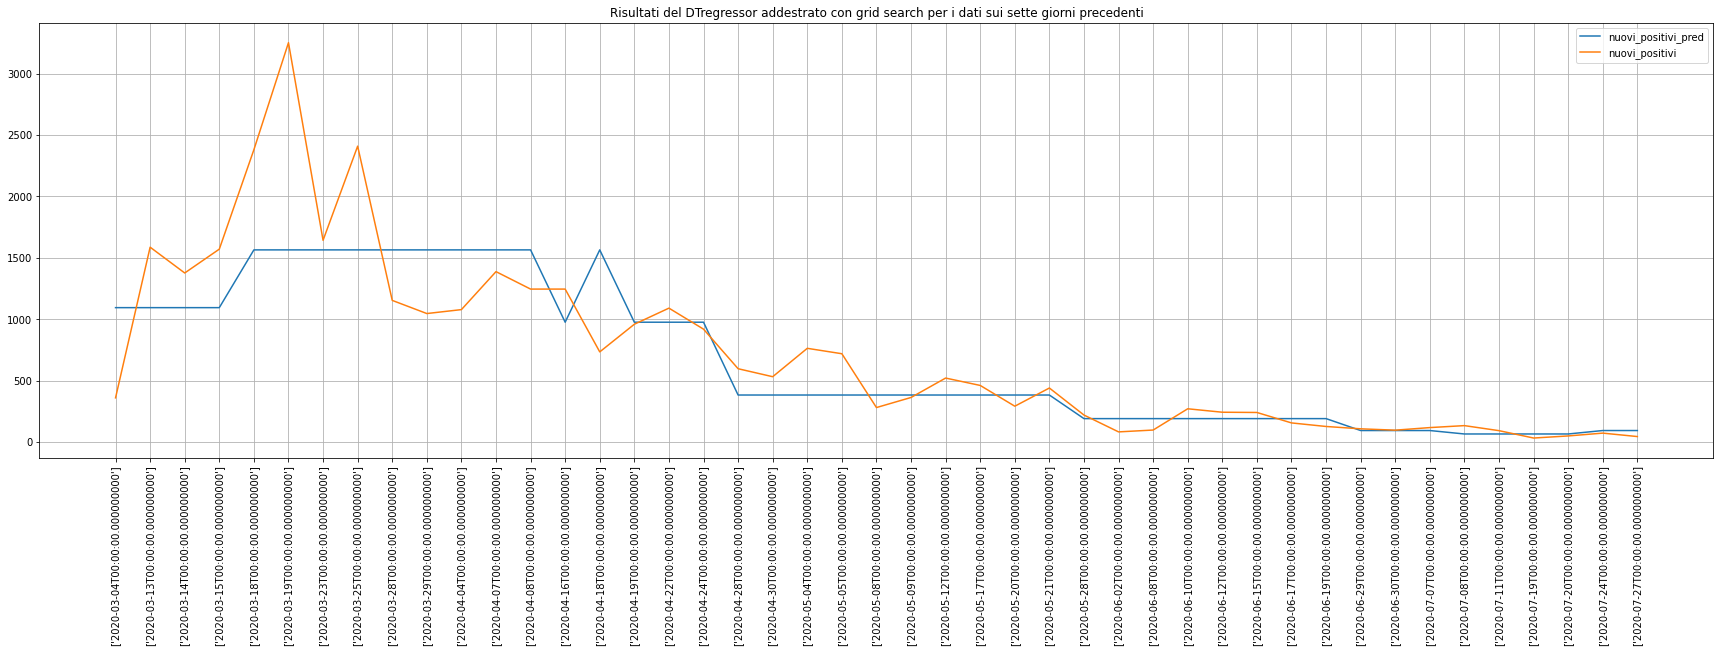

In [99]:
x_triks=df_1.loc[list(test_X_1.index),['Data']]

plt.plot(predicted_1, label="nuovi_positivi_pred")
plt.plot(test_y_1.values, label="nuovi_positivi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks.values), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search per i dati sui sette giorni precedenti")
plt.show()

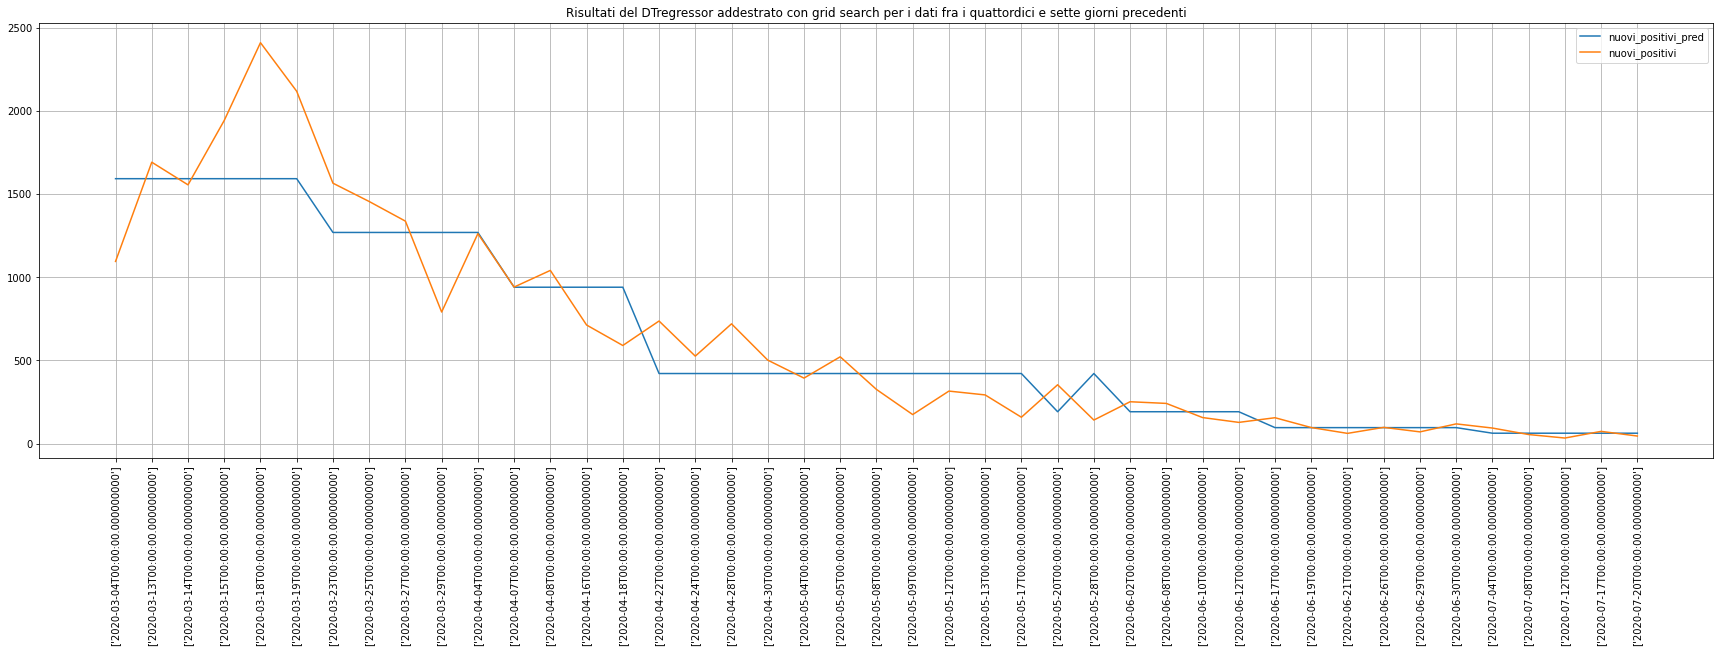

In [100]:
x_triks=df_2.loc[list(test_X_2.index),['Data']]
plt.plot(predicted_2, label="nuovi_positivi_pred")
plt.plot(test_y_2.values, label="nuovi_positivi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks.values), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search per i dati fra i quattordici e sette giorni precedenti")
plt.show()

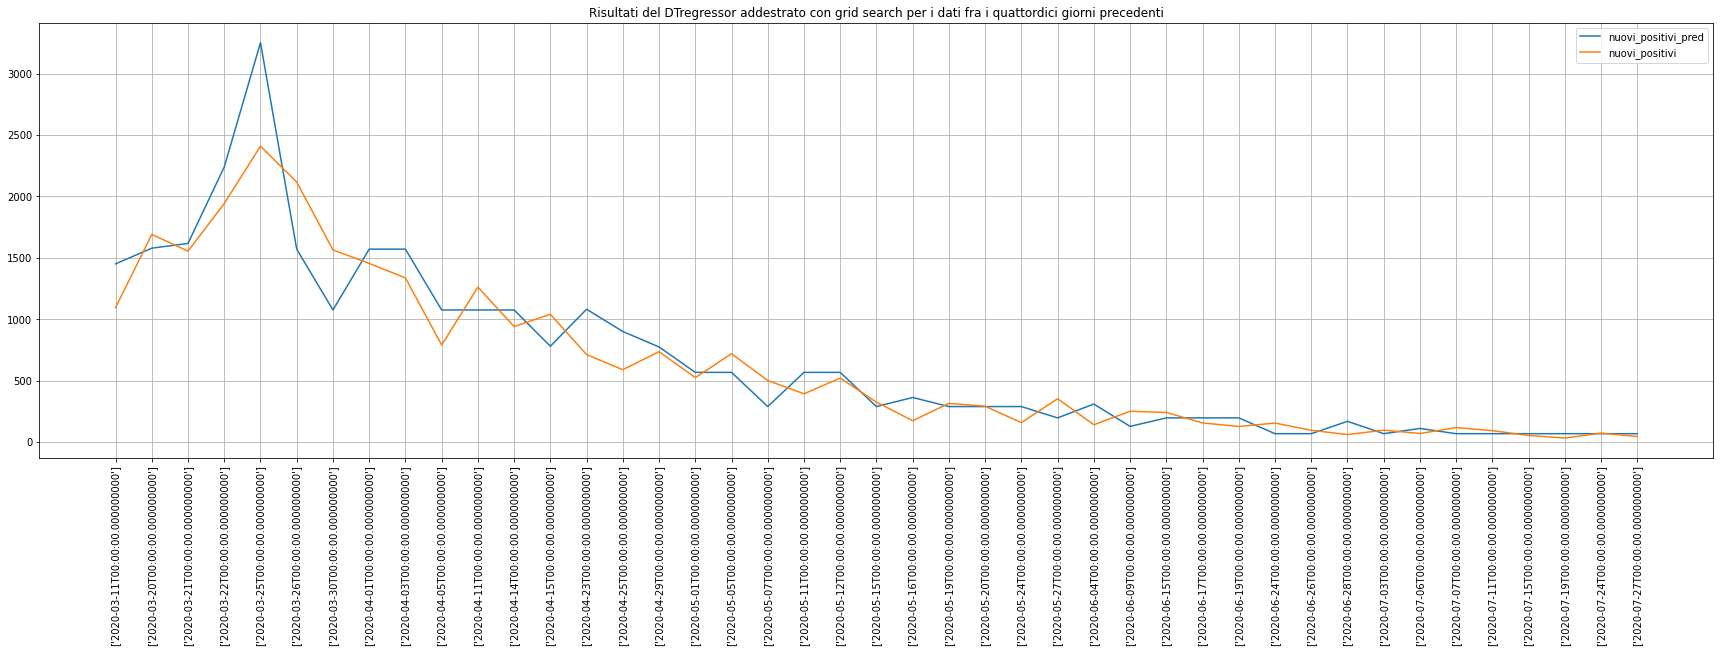

In [101]:
x_triks=df_0.loc[list(test_X_0.index),['Data']]
plt.plot(predicted_0, label="nuovi_positivi_pred")
plt.plot(test_y_0.values, label="nuovi_positivi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks.values), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search per i dati fra i quattordici giorni precedenti")
plt.show()

### MODELLO: valutazione ed osservazioni ###

Vediamo le **caratteristiche** del miglior albero di decisione trovato.

In [102]:
best_regressor_1

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.1, presort='deprecated',
                      random_state=146645, splitter='random')

In [103]:
best_regressor_2

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.1, presort='deprecated',
                      random_state=146645, splitter='best')

In [104]:
best_regressor_0

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=146645, splitter='best')

Si tratta di un DecisionTreeRegressor con splitter **random** e criterio di split **MAE** (Mean Absolute Error)

Calcoliamo alcune **misure di performance** per il regressore basato su alberi di decisione. Abbiamo scelto quelle a parer nostro più significative:
* **R2**: coefficiente di determinazione
* **RMSE**: root mean squared error
* **MAX Error**: errore massimo

Relativo alla **settiman precedente**

In [105]:
print(f"R2: \t\t{r2_score(test_y_1, predicted_1):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y_1, predicted_1, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y_1, predicted_1)}")

R2: 		0.686
RMSE: 		4.03e+02
MAX ERR: 	1686.0


Relativo fra **quattordici e sette giorni precedenti**


In [106]:
print(f"R2: \t\t{r2_score(test_y_2, predicted_2):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y_2, predicted_2, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y_2, predicted_2)}")

R2: 		0.863
RMSE: 		2.35e+02
MAX ERR: 	817.0


Relativo ai **quattordici giorni precedenti**


In [107]:
print(f"R2: \t\t{r2_score(test_y_0, predicted_0):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y_0, predicted_0, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y_0, predicted_0)}")

R2: 		0.87
RMSE: 		2.28e+02
MAX ERR: 	842.0


Possiamo **osservare** che le performance del miglior albero di decisione trovato sono abbastanza **buone**.

**R2** è **0.893**, ampiamente superiore a 0.5 ed abbastanza vicino al massimo (1). Questo vuol dire che il modello spiega gran parte della varianza dei dati.

**RMSE** è **59.7**, pertanto il nostro modello in media sbaglia il conteggio dei nuovi positivi di 60 unità. Seppur di primo acchitto sembri eccessivo, in realtà non lo è se si pensa che in alcune giornate sono stati registrati più di 1000 nuovi positivi.

**MAX ERR** è **238**. Dal grafico si nota come in un preciso giorno il predittore sbagli parecchio. Questo errore molto pronunciato va ad influenzare negativamente l'RMSE.

### MODELLO: feature importance

Visualizziamo la **feature importance** derivante dal training del miglior albero regressore.

Relativo alla **settiman precedente**

In [108]:
feature_importance = dict(zip(predictor_columns, best_regressor_1.feature_importances_))

for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])

pass_dimessi_guariti 0.7467852344699636
pass_nuovi_positivi 0.11154116819141453
pass_deceduti 0.10677499840061418
pass_totale_casi 0.029556650246305424
pass_Direzione Vento 0.002686968204209584
pass_tamponi 0.002654980487492774
pass_Altezza Neve 0.0
pass_Ammoniaca 0.0
pass_Benzene 0.0
pass_Biossido di Azoto 0.0
pass_Biossido di Zolfo 0.0
pass_BlackCarbon 0.0
pass_Livello Idrometrico 0.0
pass_Monossido di Azoto 0.0
pass_Monossido di Carbonio 0.0
pass_Ossidi di Azoto 0.0
pass_Ozono 0.0
pass_PM10 (SM2005) 0.0
pass_Particelle sospese PM2.5 0.0
pass_Precipitazione 0.0
pass_Radiazione Globale 0.0
pass_Temperatura 0.0
pass_Umidità Relativa 0.0
pass_Velocità Vento 0.0
pass_isolamento_domiciliare 0.0
pass_ricoverati_con_sintomi 0.0
pass_terapia_intensiva 0.0
pass_totale_ospedalizzati 0.0
pass_totale_positivi 0.0
pass_variazione_totale_positivi 0.0


Relativo fra **quattordici e sette giorni precedenti**


In [109]:
feature_importance = dict(zip(predictor_columns, best_regressor_2.feature_importances_))

for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])

pass_deceduti 0.754615952732644
pass_ricoverati_con_sintomi 0.11455475838784555
pass_nuovi_positivi 0.10619328972357038
pass_totale_ospedalizzati 0.02463599915594007
pass_Altezza Neve 0.0
pass_Ammoniaca 0.0
pass_Benzene 0.0
pass_Biossido di Azoto 0.0
pass_Biossido di Zolfo 0.0
pass_BlackCarbon 0.0
pass_Direzione Vento 0.0
pass_Livello Idrometrico 0.0
pass_Monossido di Azoto 0.0
pass_Monossido di Carbonio 0.0
pass_Ossidi di Azoto 0.0
pass_Ozono 0.0
pass_PM10 (SM2005) 0.0
pass_Particelle sospese PM2.5 0.0
pass_Precipitazione 0.0
pass_Radiazione Globale 0.0
pass_Temperatura 0.0
pass_Umidità Relativa 0.0
pass_Velocità Vento 0.0
pass_dimessi_guariti 0.0
pass_isolamento_domiciliare 0.0
pass_tamponi 0.0
pass_terapia_intensiva 0.0
pass_totale_casi 0.0
pass_totale_positivi 0.0
pass_variazione_totale_positivi 0.0


Relativo ai **quattordici giorni precedenti**


In [110]:
feature_importance = dict(zip(predictor_columns, best_regressor_0.feature_importances_))

for w in sorted(feature_importance, key=feature_importance.get, reverse=True):
    print(w, feature_importance[w])

pass_deceduti 0.7263268147333604
pass_totale_ospedalizzati 0.1053242571523692
pass_Precipitazione 0.04757784867839944
pass_totale_positivi 0.04134228398227005
pass_Benzene 0.02022053389352904
pass_variazione_totale_positivi 0.012209376184258176
pass_nuovi_positivi 0.012192754411985508
pass_Livello Idrometrico 0.010166327887389116
pass_Radiazione Globale 0.005768369547438161
pass_Direzione Vento 0.004761098270660302
pass_terapia_intensiva 0.003983379863371083
pass_Altezza Neve 0.0037892864541983827
pass_Monossido di Azoto 0.0029611135668024453
pass_BlackCarbon 0.0014164255578001733
pass_Ammoniaca 0.0008819774060178624
pass_Umidità Relativa 0.0005707064071370321
pass_Velocità Vento 0.0005074460030136925
pass_Biossido di Azoto 0.0
pass_Biossido di Zolfo 0.0
pass_Monossido di Carbonio 0.0
pass_Ossidi di Azoto 0.0
pass_Ozono 0.0
pass_PM10 (SM2005) 0.0
pass_Particelle sospese PM2.5 0.0
pass_Temperatura 0.0
pass_dimessi_guariti 0.0
pass_isolamento_domiciliare 0.0
pass_ricoverati_con_sintomi 0

La feature più importante per lo split è stata, senza sorpresa, **"nuovi_positivi_mean"**, ossia la media dei nuovi positivi nei 5 giorni precedenti rispetto al giorno di riferimento.

La vera sorpresa è stata la feature **"so2"**, al secondo posto per importanza, con grande distacco da tutte le altre. L'anidride solforosa sembra avere una **correlazione importante** con i nuovi positivi predetti.

Un'ultima osservazione interessante riguarda l'attributo **"region"**, che è quello meno importante di tutti. Ciò vuol dire che, con buona probabilità, il modello si comporterà bene anche con **altre zone geografiche**.

### Salvataggio e caricamento del modello ###

Scriviamo due **funzioni** ad hoc per il salvataggio ed il caricamento di modelli sci-kit learn.

In [111]:
def save_scikit_model(kind, model):
    folder = "models/" + kind + "-" + datetime.now().strftime("%d-%m-%Y %Hh%M")
    os.mkdir(folder)
    joblib.dump(model, folder + "/" + "model.joblib")
    
def load_scikit_model(folder):
    loaded_model = joblib.load(folder + "/model.joblib")
    return loaded_model

**Salviamo** il modello migliore trovato.

In [112]:
save_scikit_model("DTR-grid", best_regressor)

NameError: ignored

**Carichiamo** il modello appena salvato per verificare che non ci siano stati errori nel salvataggio.

In [ ]:
loaded_model = load_scikit_model("models/DTR-grid-08-07-2020 15h27")

loaded_predicted = loaded_model.predict(test_X_imp)